# Графовый анализ тем ВКР на программе Международные отношения в 2024 году.
Группа: Олег Князев, Дмитрий Каневский.

# 1. Описание задачи. 
К началу ноября нам, студентам, нужно выбрать тему ВКР и научного руководителя. Можно обратиться за советом к старшекурсникам, а можно сходить на сайт [ВКР ВШЭ](https://www.hse.ru/edu/vkr/), изучить темы прошлого года, сделать выводы о примерных вариантах и подобрать самостоятельно. 

TODO

[github](https://github.com/sblenlkj/Decision_Theory_HW2)

# 2. Источники данных и описательная статистика.
# 2.1 Сбор данных.
На сайте можно выбрать ВКР только нашей программы и с защитой в 2024 году. Таких работ **101**. Сам сайт выглядит вот так:

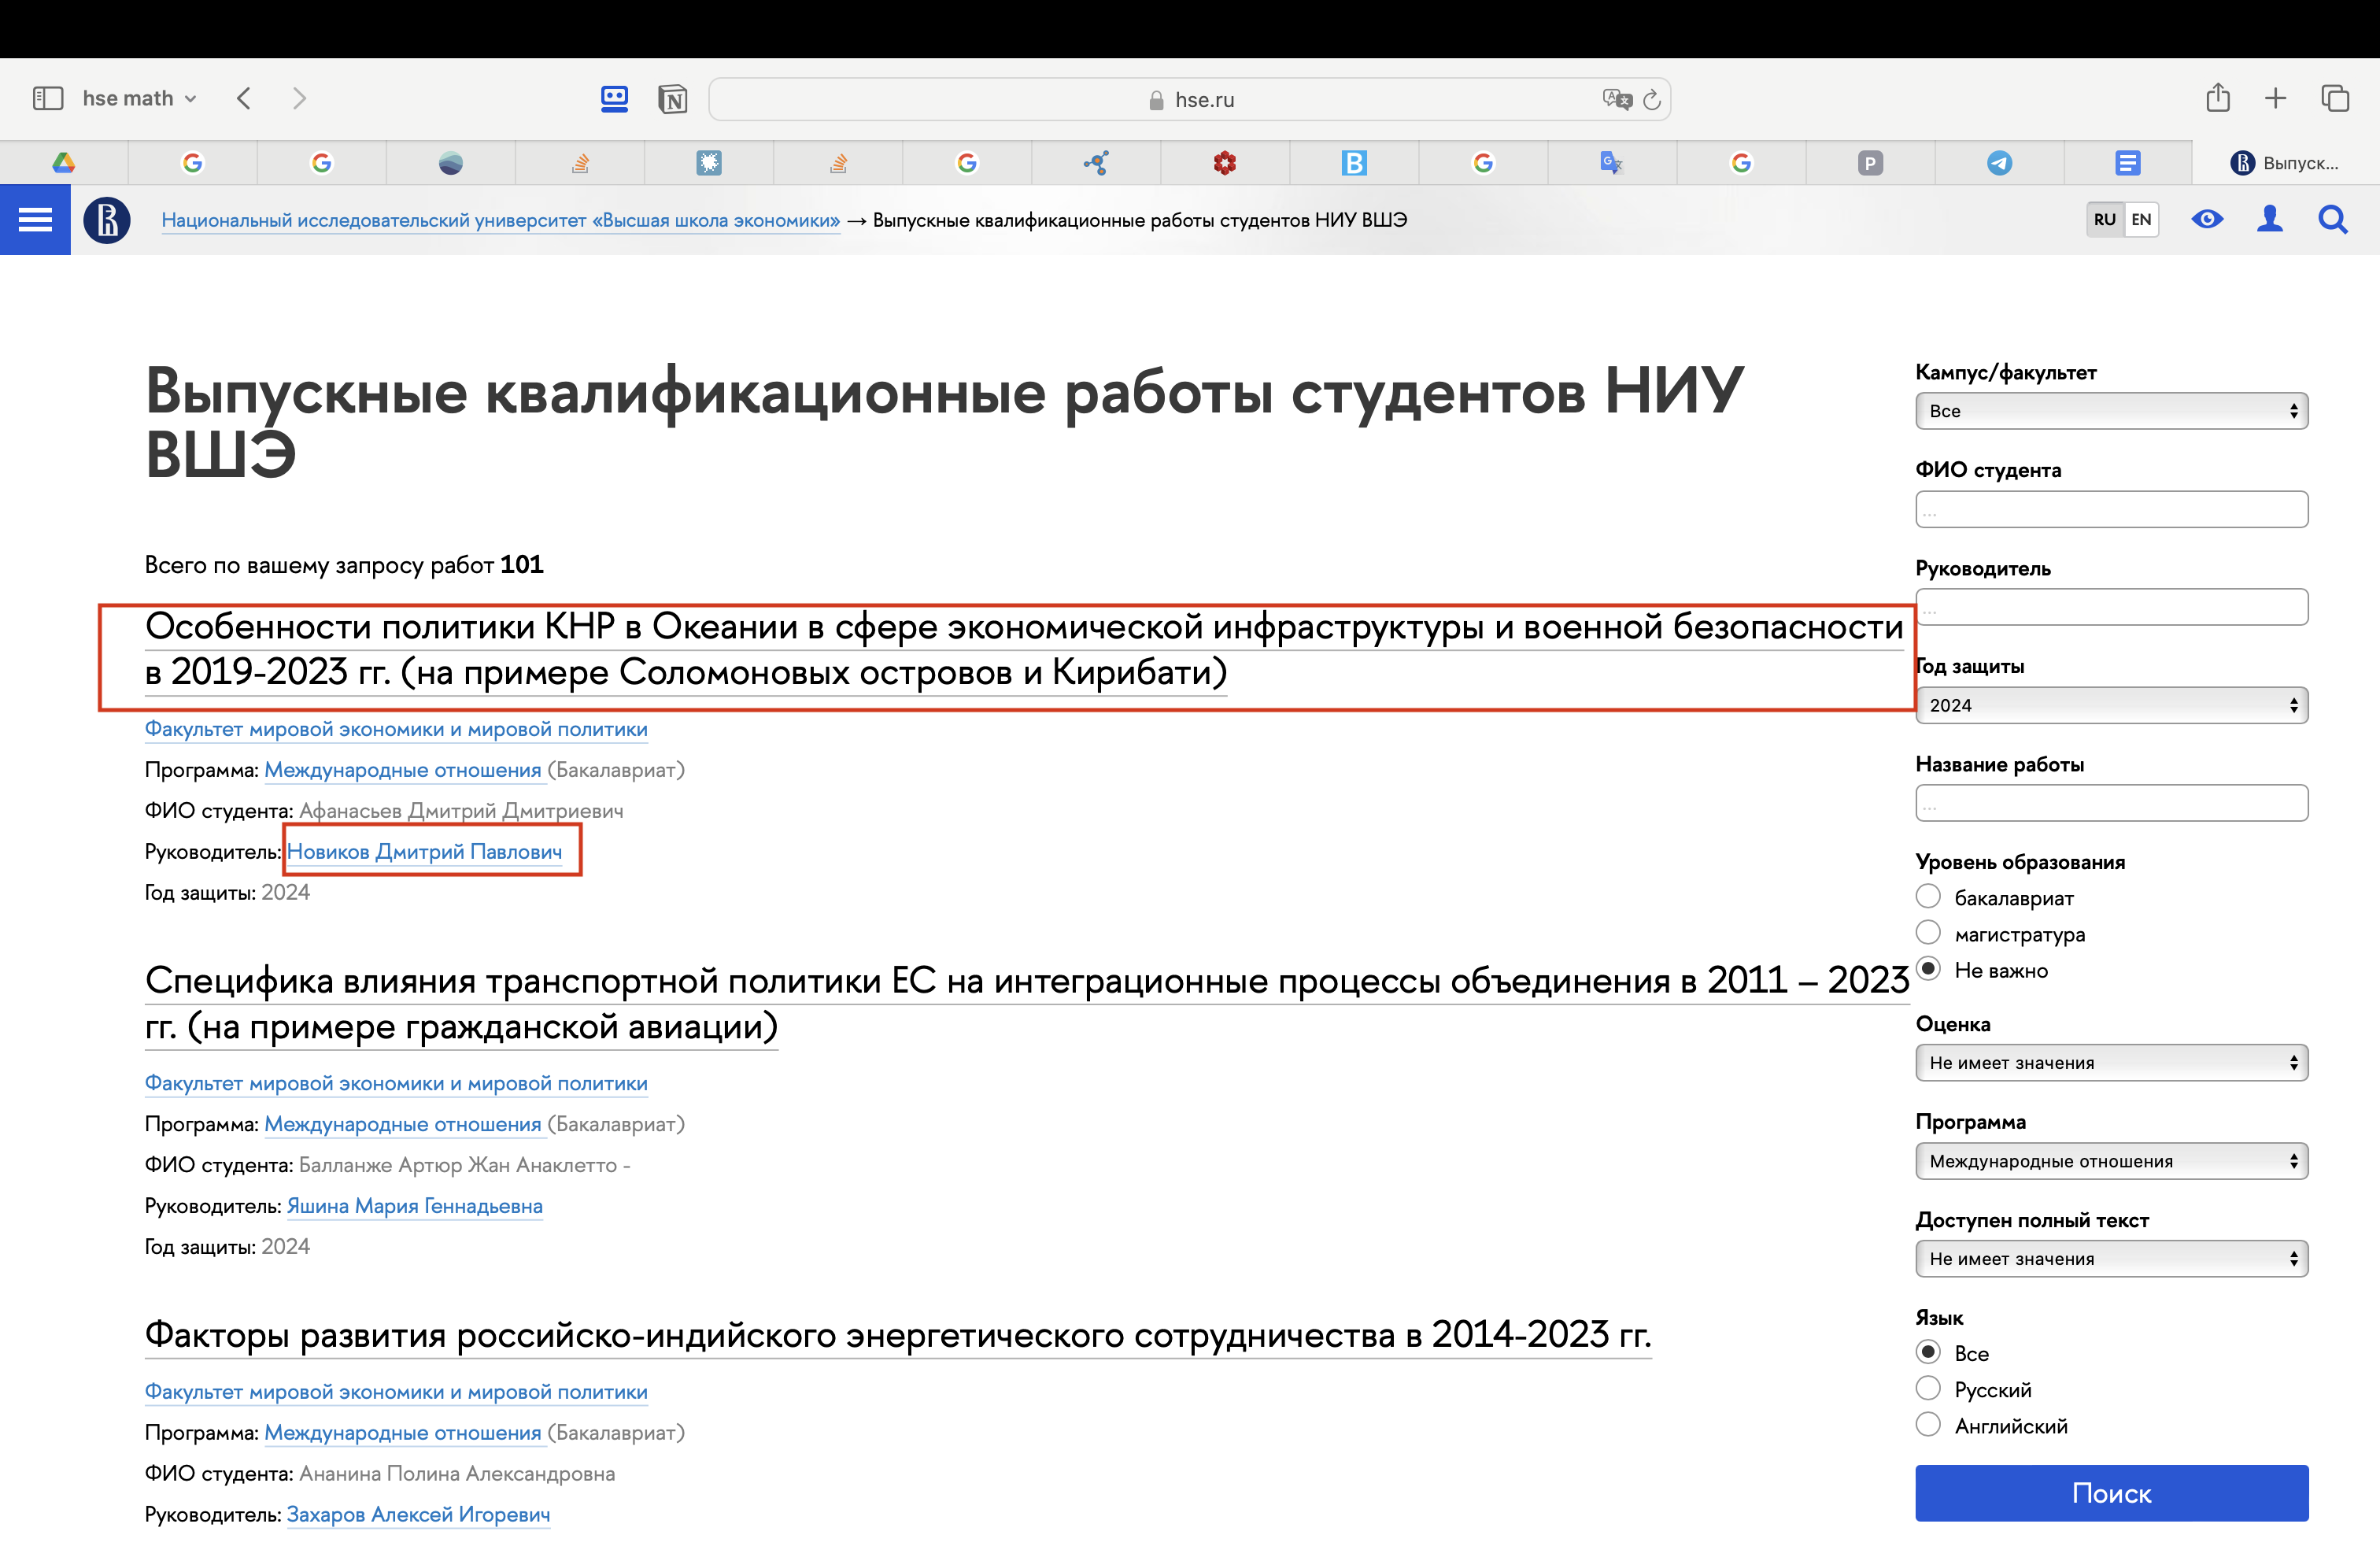

In [35]:
from IPython.display import Image
Image(filename='screens/00_hse.png', width=1000) 

Мы можем спарсить название работы, чтобы в дальнейшем выделить токены/вершины, и фамилию преподавателя. В идеале, каждый преподаватель должен специализироваться на узком спекторе тем (иметь связь с определенными вершинами) и лаконично дополнять наш граф. Также подобный подход позволит использовать граф для определения интересов конкретного преподавателя - сферой интересов будут являться связанные с ним вершины.

Все 101 темы и преподаватели были спарсены, переведены на английский для удобства, и сохранены в json: 

```json
{
    "data": {
        "1": {
            "topic": "Peculiarities of China's Policy in Oceania in the Sphere of Economic Infrastructure and Military Security in 2019-2023 (Based on the Example of the Solomon Islands and Kiribati)",
            "tutor": "Novikov"
        },
        ...
}
```

Паралельно был подготовлен txt файл, состоящий из названий работ, который затем был использован для написания промпта для llm llama3. Ее задачей было извлечь токены/вершины из тем ВКР. Стоит отметить, что традиционно в наших ВКР есть 3 составляющие:
- "кто" - страна, организация;
- "что" - сфера ВКР (энергетика, миграция, дипломатия);
- "когда" - временные рамки.

Поэтому задачей llm было также поделить токены на группы "countries" ("кто" выше) и "topics" ("что" выше). Даты во всех работах были примерно одинаковые (последние 4-5 лет), поэтому не используются в качестве токена/вершины. Результаты также были сохранены в json. ИИ сократил временные издержки, но все-равно пришлось просмотреть данные и подправить некоторые токены - в контексте дз это быстрее, чем писать новые промпты / дообучаться. Например, были:
- соединены в единый токен одинаковые термины (например, media и press, Catalan separatist movement и Catalan independence movement);
- унифицированы названия стран (Russia вместо Russian Federation, China вместо RPC).

После ручной обработки json токенов был обьединен с изначальным json тем. Макет единого json:

```json
{
    "data": {
        "1": {
            "topic": "Peculiarities of China's Policy in Oceania in the Sphere of Economic Infrastructure and Military Security in 2019-2023 (Based on the Example of the Solomon Islands and Kiribati)",
            "tutor": "Novikov",
            "countries": [
                "Oceania",
                "China",
                "Solomon Islands",
                "Kiribati"
            ],
            "topics": [
                "infrastructure",
                "security",
                "military"
            ]
        },
        ...
    
```

Теперь у нас есть токены/вершины из каждой темы. Мы считаем все токены/вершины, использованные в одной теме, связанными между собой. Также некоторые токены используются в нескольких работах, они имеют связи к нескольким "кучкам" токенов сразу, связывая граф в единое целое. Для кода ниже (построения графа и получения табличных данных для Gephi) нам достаточно данного json. Также стоит отметить, априори все вершины являются одинаковыми - мы не можем выделить направление связи, поэтому граф ненаправленный.

# 2.2. EDA.
В коде ниже часто используются различные хранилища - словари, списки, датафреймы. С целью избежать путаницы все инкапсулировано в класс MyGraph, которому достаточно только получить название нашего json файла при инициализации. Инициализируем и посмотрим на наши таблички с вершинами и связями.

In [1]:
import pandas as pd
import networkx as nx

from graph import MyGraph
g = MyGraph("2_united.json")
g.set_dfs()

g.nodes_df.head()

,node,times,type
0,Baklanov,3,tutors
1,Bartenev,1,tutors
2,Bass,4,tutors
3,Batyuk,4,tutors
4,Belous,1,tutors


In [2]:
g.connections_df.head()

,node1,node2,times
0,Novikov,Oceania,1
1,China,Novikov,4
2,Novikov,Solomon Islands,1
3,Kiribati,Novikov,1
4,Novikov,infrastructure,1


Всего **222** вершины и **1212** связи (**4.94**% от максимумально возможного числа).

In [3]:
m = sum([i for i in range(1, g.nodes_df.shape[0])])
g.nodes_df.shape[0], g.connections_df.shape[0], round(g.connections_df.shape[0] / m * 100, 2)

(222, 1212, 4.94)

Запустим DFS - проверим, что у нас цельный граф и нет отдельных частей.

In [27]:
g.is_connected()

True

Однако перед построением финального графа для дальнейшего анализа хотелось бы почистить наши данные, например, посмотреть на распределение / присутствие вершин-выбросов. Для этого нужны числовые данные, есть несколько вариантов: 
- в таблице вершин есть колонка `times` - сколько раз вершина встречалась, можно использовать эти данные;
- посчитать число связей для конкретной вершины - поработать с таблицей связей.

Последнее также отражает метрика `Degree centrality` - в питоне для ее подсчета необходимо создать nx.Graph и применить функцию nx.degree_centrality - удобно. Финальный результат нормирован на максимальное число связей - лежит в диапазоне (0, 1]. Для удобства  я умножил на 100 и округлил до 2-х знаков после запятой (получили % вместо доли). 

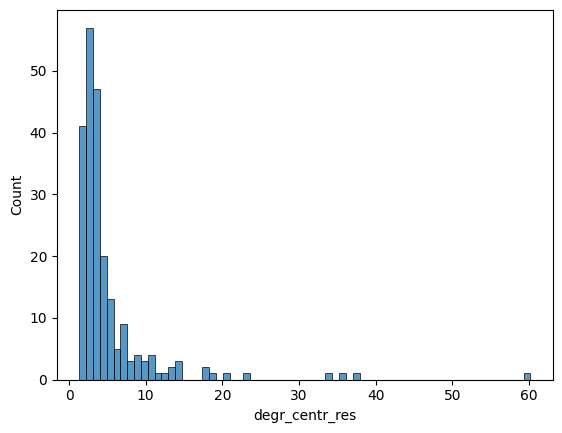

In [28]:
g.set_graph()

degr_centr_res = nx.degree_centrality(g.graph)
degr_centr_df = pd.DataFrame(degr_centr_res.items(), columns=["node", "degr_centr_res"])
degr_centr_df["degr_centr_res"] = degr_centr_df["degr_centr_res"].apply(lambda x: round(x*100, 2))

degr_centr_df_merged = pd.merge(g.nodes_df, degr_centr_df, on="node")

import seaborn as sns
sns.histplot(data=degr_centr_df_merged, x="degr_centr_res");

Распределение не нормальное, точно существуют "выбросы" - в контексте нашей задачи именно они, вершины с высокой Degree centrality (а значит, скорее всего, и с высокими показателями по другим метрикам) будут нас интересовать. На данный момент возникает 2 задачи:
- Проверить вершины преподавателей на выбросы сверху и удалить их - такие преподаватели берутся почти за любые темы, что делает их посредниками между самыми разными по смыслу вершинами и вносит немного хаоса в наш граф.
- Сократить число вершин, удалив малозначимые (судя по левой части гистограммы выше таких много) - это позволит облегчить дальнейшую работу и анализ.

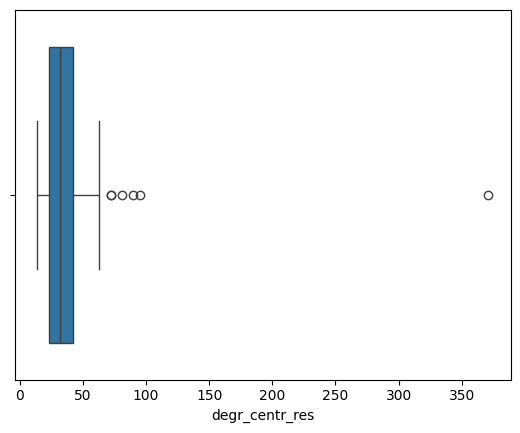

In [6]:
only_tutors_df = degr_centr_df_merged[degr_centr_df_merged['type'] == 'tutors']
sns.boxplot(data=only_tutors_df, x="degr_centr_res");

Проблема с выбросами в районе 80-100 Degree centrality будет решена ниже. Самый крайний выброс справа прийдется убрать... это Д. Новиков - только на нашей программе и только за 2024 год 28 ВКР (27.7% от общего числа) - легенда.

In [7]:
not_include_nodes_lst = ["Novikov"]
only_tutors_df.sort_values(by="degr_centr_res", ascending=False).head()

,node,times,type,degr_centr_res
22,Novikov,28,tutors,371
34,Yashina,4,tutors,95
20,Lukyanov,5,tutors,90
3,Batyuk,4,tutors,81
2,Bass,4,tutors,72


При решении второй задачи на помощь приходит метрика `Betweenness centrality`. Изходя из гистограммы и общего понимания в целом, сложившегося в процессе сбора данных, у нашего графа есть почти бессмысленные вершины - очень узкие термины, использованные только в одной работе. Такие вершины соединины только с токенами одной работы, поэтому не лежат на кратчайших путях других вершин, иными словами, их `Betweenness centrality` равна 0. 

Подобные вершины-преподаватели можно сразу удалить, а вершины других категорий для начала выведем на экран и посмотрим.

In [8]:
betw_centr_res = nx.betweenness_centrality(g.graph)
betw_centr_df = pd.DataFrame(betw_centr_res.items(), columns=["node", "betw_centr_res"])

betw_centr_df_merged = pd.merge(g.nodes_df, betw_centr_df, on="node")
betw_zero_mask = betw_centr_df_merged["betw_centr_res"] == 0
betw_centr_df_merged_masked = betw_centr_df_merged[betw_zero_mask]

not_include_nodes_lst.extend(betw_centr_df_merged_masked[betw_centr_df_merged_masked['type'] == 'tutors']['node'].values)

betw_zero_mask.sum()

np.int64(131)

По всем трем категориям таких (Betweenness centrality = 0) вершин  **131** (58.7% от общего числа). 

Посмотрим на вершины с Betweenness centrality = 0 в категории "topics" (см ниже). Как видно, это 
- специфичные термины: 'European security system', 'Transnistrian Problem', 'Neighbourhood First Policy' и т д.
- действующие лица - личности и компании: 'E. Macron', 'Adidas', 'Lula da Silva' и т д.

Включение данных токенов в название сильно зависило от настроя конктретного студента. Например, идентичная по содержанию работа могла называться "Публичная дипломатия Франции", а могла "Роль городской и культурной дипломатии в публичной дипломатия Франции при президенстве Э. Макрона" - поэтому для нас достаточно выделить только два токена (дипломатия и Франция), удалив из результатов ллм вершины с `Betweenness centrality`, равной 0. 

Выражаясь в терминах bias-variance decomposition, мы также сократили разброс для интересующих нас вершин. Предположим:
- число работ примерно одинаково год от года - подтверждается данными сайта ВКР;
- интересы (сферы тем) примерно одинаковы - мое наблюдение;

Теперь (при анализе данных за разные года, чего нет в настоящей работе) мы менее зависимы от желания студента "раздуть" название своей работы, что ведет к более постоянному числу соседей (а значит и метрик) и лучшему соответсвию между генеральной совокупностью (реально не существующему графу тем на нашей ОП) и нашей выборкой (графом, построенным по данным за 2024 год).

In [9]:
# вершины topics - просто темы
d = betw_centr_df_merged_masked[betw_centr_df_merged_masked['type'] == 'topics']['node']
not_include_nodes_lst.extend(d)
d.values[:40]

array(['Adidas', 'Big Tech', 'E. Macron', 'European security system',
       'Green Transition Strategy', 'Indo-Pacific Initiative',
       'Jair Bolsonaro', 'Kurdish separatist', 'Lula da Silva',
       'Neighbourhood First Policy', 'Neutrality Policy', 'Nike',
       'Official development assistance', 'Operation Barkhane', 'Paris',
       'Rome', 'South China Sea', 'Sustainable Development',
       'Syrian Crisis', 'Taiwan factor', 'Transnistrian Problem', 'Trump',
       'Yemen Conflict', 'alliance', 'analytical centers', 'aviation',
       'balance', 'city', 'degradation', 'diaspora', 'digital economy',
       'digital silk road', 'domestic', 'drug control', 'ecology',
       'education', 'education cooperation', 'elections',
       'energy transformation', 'extremism'], dtype=object)

С вершинами с Betweenness centrality = 0 в категории "countries" все сложнее: простое удаление приведет к значительной потере данных. Например, можно заметить, что:
- Будут удалены все страны и регионы Африки - 'Algeria', "Côte d'Ivoire", 'Mali', 'Nigeria', 'Sahel', 'North Africa'. У нас не останется ни одного токена, показывающего, что минимум 3-4 работы все-таки были посвящены Африки. Нужно просмотреть данные снова и добавить токен 'Africa'.
- Немного иная судьба постигнет страны Ближнего Востока - 'Yemen' и 'United Arab Emirates' исчезнут, останется только 'Saudi Arabia'. По моим ощушениям, несколько работ о 'Saudi Arabia' в одном году - тоже выброс. Нужно заменить данные токены на нечто обобщающее - Middle East. Аналогичная история наблюдается в Средней Азии (слишком много Узбекистана, Казахстана, Таджикистана), Юго-Восточной Азии и т д. 

In [10]:
# вершины countries - страны и регионы - с Betweenness centrality = 0
d = betw_centr_df_merged_masked[betw_centr_df_merged_masked['type'] == 'countries']['node']
not_include_nodes_lst.extend(d)
d.values

array(['Afghanistan', 'Algeria', 'Austria', 'Belarus', 'Canada',
       'Caribbean', 'Colombia', "Côte d'Ivoire", 'East Asia', 'Hungary',
       'Indo-Pacific region', 'Indonesia', 'Kiribati', 'Kyrgyzstan',
       'Mali', 'Morocco', 'NATO', 'New Zealand', 'Nigeria',
       'North Africa', 'North Korea', 'Philippines', 'Poland', 'Sahel',
       'Solomon Islands', 'Sri Lanka', 'United Arab Emirates',
       'Venezuela', 'West', 'Yemen'], dtype=object)

In [11]:
# вершины countries - страны и регионы - с Betweenness centrality != 0
betw_centr_df_merged[(betw_centr_df_merged['type'] == 'countries') & (~betw_zero_mask)]['node'].values

array(['ASEAN', 'Argentina', 'BRICS', 'Brazil', 'Central Asia', 'China',
       'EU', 'France', 'Germany', 'India', 'Iran', 'Italy', 'Japan',
       'Kazakhstan', 'Latin America', 'Mexico', 'Moldova', 'Oceania',
       'Russia', 'Saudi Arabia', 'Serbia', 'South Korea', 'Spain',
       'Syria', 'Tajikistan', 'Turkey', 'UK', 'UN', 'US', 'Ukraine',
       'Uzbekistan', 'Vietnam'], dtype=object)

Измененные данные лежат в `2_united_corrected.json`, создадим ключи nodes и connections (сохранится в файл `3_final_corrected.json`) с учетом невключаемых вершин not_include_nodes_lst и сможем вернуться к графовому анализу на более хороших данных.

In [36]:
new_g = MyGraph("2_united_corrected.json", not_lst=not_include_nodes_lst)
new_g.set_dfs()
new_g.set_graph()

m = sum([i for i in range(1, new_g.nodes_df.shape[0])])
new_g.nodes_df.shape[0], new_g.connections_df.shape[0], round(new_g.connections_df.shape[0] / m * 100, 2)

(90, 580, 14.48)

Теперь у нас **90** вершин и **580** ребра (**14.48**% от максимумально возможного числа, почти в 3 раза больше, чем в графе на сырых данных). Граф стал более связанным, стало лучше, что также можно видеть по ящикам с усами ниже - метрика `Degree Centrality` по всем трем категориям вершин. 

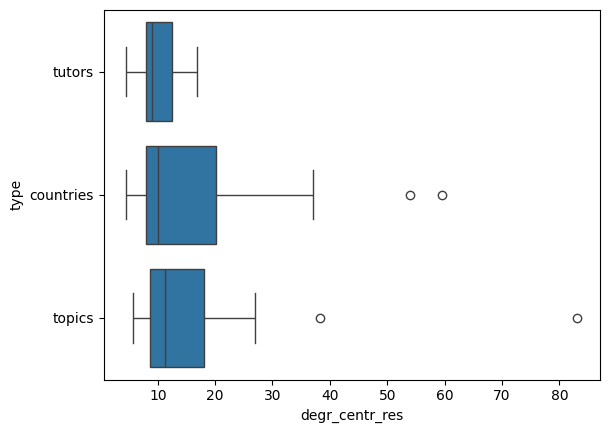

In [37]:
degr_centr_res = nx.degree_centrality(new_g.graph)
degr_centr_df = pd.DataFrame(degr_centr_res.items(), columns=["node", "degr_centr_res"])
degr_centr_df["degr_centr_res"] = degr_centr_df["degr_centr_res"].apply(lambda x: round(x*100, 1))

degr_centr_df_merged = pd.merge(new_g.nodes_df, degr_centr_df, on="node")

sns.boxplot(data=degr_centr_df_merged, x="degr_centr_res", y="type");

Граф по-прежнему связан:

In [38]:
new_g.is_connected()

True

Теперь можно сохранить наши данные в csv файлы, подгрузить их в Gephi, посчитать основные характеристики сети и повизуализировать.

In [39]:
new_g.save_dfs() 

# 3. Расчеты и результаты. 
# 3.1. Cеть в Gephi

TODO (＊◕ᴗ◕＊)

# 3.2. Результаты в широкой перспективе.

В целом можно заметить, что топ-10 вершин почти неизменен, несмотря на тип использованной метрики. Это более наглядно представлено на таблице ниже и говорит о том, что данные вершины:
- имеют наибольшее число соседей - вывод по Degree centrality;
- и почти полностью взаимосвязаны друг с другом - вывод по Eigenvector centrality;
- и лежат в центре нашего графа - вывод по Load centrality;
- и при этом связывают более крайние вершины, не имеющие ребер между собой - вывод по Betweenness centrality.

Забавно, что вершины топ-10 идеально описывают содержание всех 4-х лет нашей программы:
- мы постоянно говорим о Russia, US, China, EU
- обсуждаем политику, внешнеполитические программы - вершины policy, foreign
- а также отношения (вершина interaction), безопасность (security) и т д

In [16]:
all_4_metrics_df = new_g.calculate_all_4_metrics()
place_columns_lst = [c for c in all_4_metrics_df.columns if "result" not in c]
all_4_metrics_df.loc[:, place_columns_lst].sort_values(by="degr_place").head(15)

,node,type,degr_place,eigenr_place,betw_place,load_place
80,policy,topics,1,1,1,1
46,US,countries,2,3,2,2
36,Russia,countries,3,2,3,3
73,interaction,topics,4,5,4,4
24,EU,countries,5,4,5,5
23,China,countries,6,6,6,6
68,energy,topics,7,7,8,8
25,France,countries,8,9,7,7
85,security,topics,9,8,10,13
69,foreign,topics,9,12,9,9


Придерживаясь логики выше можно посмотреть на аномалии (большой разброс в местах по 4 метрикам) и попробовать обьяснить их причины.

TODO (＊◕ᴗ◕＊)

# * Page rank и составление темы ВКР.

Однако также можно попробовать извлечь практическую пользу из нашего графа - попробовать составить себе тему ВКР. При этом у нас есть неиспользованные прежде данные - веса вершин и веса ребер - было бы замечательно учитывать также их - посчитаем page rank. 

Для сравнения запустим без весов и с весами.

In [41]:
results = nx.pagerank(new_g.graph)
df = pd.DataFrame(results.items(), columns=["node", "result"])
df["result"] = df["result"].round(4)

df.sort_values("result", ascending=False).head(10)

,node,result
80,policy,0.0580
47,US,0.0418
38,Russia,0.0373
73,interaction,0.0274
25,EU,0.0260
24,China,0.0222
26,France,0.0195
68,energy,0.0189
85,security,0.0184
69,foreign,0.0180


In [42]:
new_g.set_graph(use_weight_edges=True)

pagerank_results = nx.pagerank(new_g.graph, personalization=new_g.nodes_weight_dct)
df = pd.DataFrame(pagerank_results.items(), columns=["node", "result"])
df["result"] = df["result"].round(4)

df.sort_values("result", ascending=False).head(10)

,node,result
80,policy,0.1109
38,Russia,0.0552
47,US,0.0513
25,EU,0.0362
68,energy,0.0307
73,interaction,0.0283
26,France,0.0256
24,China,0.0225
65,diplomacy,0.0201
69,foreign,0.0192


Как видно выше даже в топ-10 результаты немного поменялись. Запустим наш алгоритм, предствляющий собой подобие 
Beam search с окном 10. Он учитывает наличие связей между вершинами и пытается собрать темы из n токенов (вершин) путем максимализации произведения результатов pagerank отобранных вершин. 

Я учу итальянский, поэтому пишу об Италии - начнем с вершины 'Italy' и соберем еще 2 токена - получим примерную тему:

In [43]:
from predict import MyPredicter
p = MyPredicter(pagerank_results, new_g.connection_relation_dct)
_ = p.find_thesis(2, node_name="Italy")

1. "Italy, policy, Russia" (acc value = 100)
2. "Italy, policy, US" (acc value = 93)
3. "Italy, policy, EU" (acc value = 66)
4. "Italy, policy, energy" (acc value = 56)
5. "Italy, policy, interaction" (acc value = 51)
6. "Italy, France, policy" (acc value = 47)
7. "Italy, Russia, US" (acc value = 46)
8. "Italy, policy, China" (acc value = 41)
9. "Italy, diplomacy, policy" (acc value = 37)
10. "Italy, policy, foreign" (acc value = 35)


Результаты очень шаблонные: первые три просто "Политика в Италии в отношении ...". Четвертая строчка - уже лучше, мы смогли отгадать тему моей собственной ВКР этого года - "Трансформация внешней энергетической политики Италии в 2021-2024 гг". Отдельно приятно, что в нашем графе нет связи между энергетикой и Италией - мы смогли попасть туда (собрать единую тему) только через посредничество вершины policy. 

In [26]:
"energy" in new_g.connection_relation_dct["Italy"]

False

В целом было забавно позапускать с 3 токенами, взять другую вершину старта... Алгоритм (можно добавить штрафы за чрезмерное число стран в теме, например) и данные (пособирать по всему факультету) очень примитивные, но результат уже есть - получилось интересно, да в реальной жизни подобный доработанный граф точно нашел бы приминение при подборе темы/научных руководителей на нашей программе. 

# 4 Выводы

TODO (＊◕ᴗ◕＊)